# 预测视频文件

使用训练好的图像分类模型，对视频文件进行逐帧预测。

同济子豪兄：https://space.bilibili.com/1900783

[代码运行云GPU环境](https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1)：GPU RTX 3060、CUDA v11.2

## 设置Matplotlib中文字体

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# # windows操作系统
# plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
# plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [5]:
# Mac操作系统，参考 https://www.ngui.cc/51cto/show-727683.html
# 下载 simhei.ttf 字体文件
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

In [6]:
# Linux操作系统，例如 云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1
# 如果遇到 SSL 相关报错，重新运行本代码块即可
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf -O /environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf
!rm -rf /home/featurize/.cache/matplotlib

import matplotlib
matplotlib.rc("font",family='SimHei') # 中文字体


--2023-03-26 18:14:18--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf
正在连接 172.16.0.13:5848... 已连接。
已发出 Proxy 请求，正在等待回应... 200 OK
长度： 10050868 (9.6M) [application/x-font-ttf]
正在保存至: “/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf”

/environment/minico 100%[===================>]   9.58M  21.5MB/s    用时 0.4s    

2023-03-26 18:14:19 (21.5 MB/s) - 已保存 “/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf” [10050868/10050868])



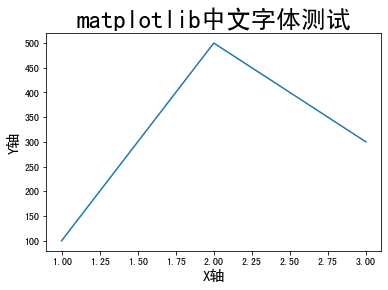

In [7]:
plt.plot([1,2,3], [100,500,300])
plt.title('matplotlib中文字体测试', fontsize=25)
plt.xlabel('X轴', fontsize=15)
plt.ylabel('Y轴', fontsize=15)
plt.show()

## 导入pillow中文字体

In [8]:
from PIL import ImageFont, ImageDraw
# 导入中文字体，指定字号
font = ImageFont.truetype('SimHei.ttf', 32)

## 导入工具包

In [9]:
import os
import time
import shutil
import tempfile
from tqdm import tqdm

import cv2
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
import gc

import torch
import torch.nn.functional as F
from torchvision import models

import mmcv

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda:0


/environment/miniconda3/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '


In [10]:
# 后端绘图，不显示，只保存
import matplotlib
matplotlib.use('Agg')

## 载入类别

In [11]:
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()

## 导入训练好的模型

In [13]:
model = torch.load('checkpoint/fruit30_pytorch_20220814.pth')
model = model.eval().to(device)

## 图像预处理

In [14]:
from torchvision import transforms

# 测试集图像预处理-RCTN：缩放裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 图像分类预测函数（同上个教程）

In [15]:
def pred_single_frame(img, n=5):
    '''
    输入摄像头画面bgr-array，输出前n个图像分类预测结果的图像bgr-array
    '''
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR 转 RGB
    img_pil = Image.fromarray(img_rgb) # array 转 pil
    input_img = test_transform(img_pil).unsqueeze(0).to(device) # 预处理
    pred_logits = model(input_img) # 执行前向预测，得到所有类别的 logit 预测分数
    pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算
    
    top_n = torch.topk(pred_softmax, n) # 取置信度最大的 n 个结果
    pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析出类别
    confs = top_n[0].cpu().detach().numpy().squeeze() # 解析出置信度
    
    # 在图像上写字
    draw = ImageDraw.Draw(img_pil)
    # 在图像上写字
    for i in range(len(confs)):
        pred_class = idx_to_labels[pred_ids[i]]
        text = '{:<15} {:>.3f}'.format(pred_class, confs[i])
        # 文字坐标，中文字符串，字体，rgba颜色
        draw.text((50, 100 + 50 * i), text, font=font, fill=(255, 0, 0, 1))
        
    img_bgr = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR) # RGB转BGR
        
    return img_bgr, pred_softmax

## 视频预测

### 输入输出视频路径

In [23]:
input_video = 'test_img/fruits_video.mp4'
output_path = 'output/output_pred.mp4'

### 可视化方案一：原始图像+预测结果文字

In [24]:
# 创建临时文件夹，存放每帧结果
temp_out_dir = time.strftime('%Y%m%d%H%M%S')
os.mkdir(temp_out_dir)
print('创建临时文件夹 {} 用于存放每帧预测结果'.format(temp_out_dir))

创建临时文件夹 20230326181816 用于存放每帧预测结果


In [25]:
# 读入待预测视频
imgs = mmcv.VideoReader(input_video)

prog_bar = mmcv.ProgressBar(len(imgs))

# 对视频逐帧处理
for frame_id, img in enumerate(imgs):
    
    ## 处理单帧画面
    img, pred_softmax = pred_single_frame(img, n=5)

    # 将处理后的该帧画面图像文件，保存至 /tmp 目录下
    cv2.imwrite(f'{temp_out_dir}/{frame_id:06d}.jpg', img)
    
    prog_bar.update() # 更新进度条

# 把每一帧串成视频文件
mmcv.frames2video(temp_out_dir, output_path, fps=imgs.fps, fourcc='mp4v')

shutil.rmtree(temp_out_dir) # 删除存放每帧画面的临时文件夹
print('删除临时文件夹', temp_out_dir)
print('视频已生成', output_path)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 211/211, 27.8 task/s, elapsed: 8s, ETA:     0s[                                                  ] 0/211, elapsed: 0s, ETA:
删除临时文件夹 20230326181816
视频已生成 output/output_pred.mp4


### 可视化方案二：原始图像+预测结果文字+各类别置信度柱状图

In [30]:
input_video = 'test_img/fruits_video.mp4'
output_path = 'output/output_bar.mp4'

In [31]:
def pred_single_frame_bar(img):
    '''
    输入pred_single_frame函数输出的bgr-array，加柱状图，保存
    '''
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR 转 RGB
    fig = plt.figure(figsize=(18,6))
    # 绘制左图-视频图
    ax1 = plt.subplot(1,2,1)
    ax1.imshow(img)
    ax1.axis('off')
    # 绘制右图-柱状图
    ax2 = plt.subplot(1,2,2)
    x = idx_to_labels.values()
    y = pred_softmax.cpu().detach().numpy()[0] * 100
    ax2.bar(x, y, alpha=0.5, width=0.3, color='yellow', edgecolor='red', lw=3)
    plt.xlabel('类别', fontsize=20)
    plt.ylabel('置信度', fontsize=20)
    ax2.tick_params(labelsize=16) # 坐标文字大小
    plt.ylim([0, 100]) # y轴取值范围
    plt.xlabel('类别',fontsize=25)
    plt.ylabel('置信度',fontsize=25)
    plt.title('图像分类预测结果', fontsize=30)
    plt.xticks(rotation=90) # 横轴文字旋转
    
    plt.tight_layout()
    fig.savefig(f'{temp_out_dir}/{frame_id:06d}.jpg')
    # 释放内存
    fig.clf()
    plt.close()
    gc.collect()

In [32]:
# 创建临时文件夹，存放每帧结果
temp_out_dir = time.strftime('%Y%m%d%H%M%S')
os.mkdir(temp_out_dir)
print('创建临时文件夹 {} 用于存放每帧预测结果'.format(temp_out_dir))

创建临时文件夹 20230326181920 用于存放每帧预测结果


In [33]:
# 读入待预测视频
imgs = mmcv.VideoReader(input_video)

prog_bar = mmcv.ProgressBar(len(imgs))

# 对视频逐帧处理
for frame_id, img in enumerate(imgs):
    
    ## 处理单帧画面
    img, pred_softmax = pred_single_frame(img, n=5)
    img = pred_single_frame_bar(img)
    
    prog_bar.update() # 更新进度条

# 把每一帧串成视频文件
mmcv.frames2video(temp_out_dir, output_path, fps=imgs.fps, fourcc='mp4v')

shutil.rmtree(temp_out_dir) # 删除存放每帧画面的临时文件夹
print('删除临时文件夹', temp_out_dir)
print('视频已生成', output_path)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 211/211, 102.4 task/s, elapsed: 2s, ETA:     0s[                                                  ] 0/211, elapsed: 0s, ETA:
删除临时文件夹 20230326181920
视频已生成 output/output_bar.mp4
